In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.utils import np_utils
import seaborn as sns

%matplotlib inline

In [71]:
# load data
train = pd.read_csv("./train.csv", index_col=0)
test = pd.read_csv("./test.csv", index_col=0).reset_index(drop=True)
submission = pd.read_csv("./sample_submission.csv")

In [72]:
train = train.dropna()
train = train.drop(train[train['dered_g']==-9999].index)
train = train.drop(train[train['dered_i']==-9999].index)
train = train.drop(train[train['dered_z']==-9999].index).reset_index(drop=True)

In [73]:
#유용한 값들 추가
train['u-g'] = train['u'] - train['g']
train['g-r'] = train['g'] - train['r']
train['r-i'] = train['r'] - train['i']
train['i-z'] = train['i'] - train['z']
train['dered_u-g'] = train['dered_u'] - train['dered_g']
train['dered_g-r'] = train['dered_g'] - train['dered_r']
train['dered_r-i'] = train['dered_r'] - train['dered_i']
train['dered_i-z'] = train['dered_i'] - train['dered_z']

test['u-g'] = test['u'] - test['g']
test['g-r'] = test['g'] - test['r']
test['r-i'] = test['r'] - test['i']
test['i-z'] = test['i'] - test['z']
test['dered_u-g'] = test['dered_u'] - test['dered_g']
test['dered_g-r'] = test['dered_g'] - test['dered_r']
test['dered_r-i'] = test['dered_r'] - test['dered_i']
test['dered_i-z'] = test['dered_i'] - test['dered_z']

In [74]:
# n값 처리
train['nO-nD'] = train['nObserve'] - train['nDetect']
train = train.drop(['nObserve', 'nDetect', 'airmass_u', 'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z'], axis=1)

test['nO-nD'] = test['nObserve'] - test['nDetect']
test = test.drop(['nObserve', 'nDetect', 'airmass_u', 'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z'], axis=1)

In [77]:
print(f'Size of training data: {train.shape}')
print(f'Size of test data: {test.shape}')

Size of training data: (319996, 21)
Size of test data: (80000, 20)


In [78]:
Y = to_categorical(train['class'], num_classes=3)
del train['class']

robust_scaler = RobustScaler()
robust_scaler.fit(train)
X = pd.DataFrame(data=robust_scaler.transform(train), columns=train.columns)
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.25,random_state=42)

In [79]:
# create a deep neural network model
num_features = X_train.shape[1]
dnn = Sequential()
dnn.add(Dense(32, input_dim=num_features, activation='relu'))
dnn.add(Dropout(0.1))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dropout(0.1))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dropout(0.05))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dropout(0.05))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dense(3, activation='softmax', name='output'))

dnn.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['categorical_accuracy'])

In [80]:
# train DNN
my_epochs = 20
history = dnn.fit(X_train, Y_train, epochs=my_epochs, batch_size=64,
                    validation_data=(X_val, Y_val))

Epoch 1/15
24000/24000 [==============================] - 24s 1ms/step - loss: 0.2567 - categorical_accuracy: 0.9032 - val_loss: 0.1974 - val_categorical_accuracy: 0.9189
Epoch 2/15
24000/24000 [==============================] - 25s 1ms/step - loss: 0.2071 - categorical_accuracy: 0.9184 - val_loss: 0.2133 - val_categorical_accuracy: 0.9186
Epoch 3/15
24000/24000 [==============================] - 25s 1ms/step - loss: 0.2001 - categorical_accuracy: 0.9205 - val_loss: 0.1996 - val_categorical_accuracy: 0.9189
Epoch 4/15
24000/24000 [==============================] - 24s 1ms/step - loss: 0.1968 - categorical_accuracy: 0.9205 - val_loss: 0.2210 - val_categorical_accuracy: 0.9072
Epoch 5/15
24000/24000 [==============================] - 24s 988us/step - loss: 0.1934 - categorical_accuracy: 0.9217 - val_loss: 0.1823 - val_categorical_accuracy: 0.9250
Epoch 6/15
24000/24000 [==============================] - 24s 998us/step - loss: 0.1913 - categorical_accuracy: 0.9226 - val_loss: 0.1838 - val

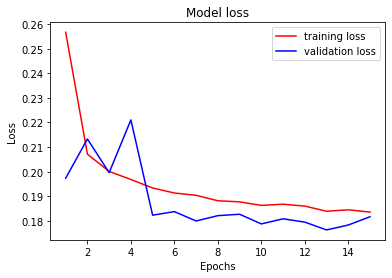

In [81]:
# plot model loss while training
epochs_arr = np.arange(1, my_epochs + 1, 1)
my_history = history.history
line1 = plt.plot(epochs_arr, my_history['loss'], 'r-', label='training loss')
line2 = plt.plot(epochs_arr, my_history['val_loss'], 'b-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.show()

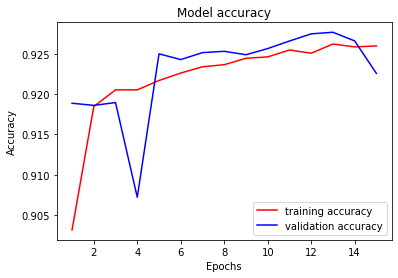

In [82]:
# plot model accuracy while training
line1 = plt.plot(epochs_arr, my_history['categorical_accuracy'], 'r-', label='training accuracy')
line2 = plt.plot(epochs_arr, my_history['val_categorical_accuracy'], 'b-', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model accuracy')
plt.legend()
plt.show()

In [83]:
preds = pd.DataFrame(dnn.predict(X_val))
preds = preds.idxmax(axis=1)
Y_val = Y_val.dot([0,1,2])
model_acc = (preds == Y_val).sum().astype(float) / len(preds) * 100

print('Deep Neural Network')
print('Validation Accuracy: %3.5f' % (model_acc))

Deep Neural Network
Validation Accuracy: 92.25615
